# Uniformity

This notebook aims to examine different metrics for the assessment of the uniformity of Ribo-Seq data based on their metagene profile 

## Setup


In [2]:
!pip uninstall RiboMetric -y
!pip install git+https://github.com/JackCurragh/RiboMetric.git -q 
!pip install plotly pandas numpy scikit-learn -q

Found existing installation: RiboMetric 0.1.9
Uninstalling RiboMetric-0.1.9:
  Successfully uninstalled RiboMetric-0.1.9


In [3]:
from RiboMetric.metrics import (
    uniformity_autocorrelation,
    uniformity_entropy,
    uniformity_gini_index,
    uniformity_theil_index,
    )

import itertools
import numpy as np


import plotly.graph_objects as go
import pandas as pd


## Simulated Inputs


In [4]:
import itertools
import random

def generate_read_frame_distribution_permutations():
    """
    Generate all possible permutations of read frame distributions that sum to 100.
    
    Args:
        None

    Returns:
        simulated_read_frame_proportions (dict): Dictionary containing all possible read frame distributions that sum to 100.
    """
    # Generate permutations
    numbers = range(1, 101)

    permutations = []
    for i, perm in enumerate(itertools.permutations(numbers, 3)):
        if sum(perm) == 100:
            # if i % 5 == 0:
            permutations.append(perm)

    # Simulate read frame proportions
    simulated_read_frame_proportions = {}
    for i, perm in enumerate(permutations):
        simulated_read_frame_proportions[i] = {0: perm[0], 1: perm[1], 2: perm[2]}

    return simulated_read_frame_proportions


def generate_metagene(frame_ratios, start, stop, noise_factor=0.8, max_count=1):
    """
    Generate a metagene dictionary with varying degrees of periodicity based on frame ratios.
    
    Args:
        frame_ratios (dict): A dictionary representing the global ratio of reads per frame.
                             Keys are frame positions (0, 1, 2), and values are the corresponding ratios.
        start (int): The start position of the metagene.
        stop (int): The stop position of the metagene.
    
    Returns:
        dict: A dictionary representing the metagene, where keys are positions and values are counts.
    """
    metagene = {}
    
    # Initialize all positions with a small constant value
    for pos in range(start, stop):
        metagene[pos] = 1
    
    # Adjust counts based on frame ratios
    for pos in range(start, stop):
        frame = (pos - start) % 3
        metagene[pos] += int(frame_ratios[frame] * max_count)
    
    # Introduce some random noise
    for pos in range(start, stop):
        metagene[pos] += int(random.uniform(0, noise_factor * max_count))
    
    return metagene



In [5]:

def generate_permuted_profile_with_bins(base_profile, num_bins=5):
    """
    Generate permuted profiles with varying degrees of variation across the entire profile, using bins and weights.
    
    Args:
        base_profile (list): The base read count profile.
        num_bins (int): Number of bins to divide the profile into.
    
    Returns:
        dict: position: counts profiles with varying degrees of variation
    """
    bin_indices = np.linspace(0, len(base_profile), num_bins + 1, dtype=int)
    permuted_profiles = {}
    # Iterate over all combinations of weights
    for idx, bin_weights in enumerate(itertools.product(range(num_bins + 1), repeat=num_bins)):
        permuted_profile = []
        for i, weight in enumerate(bin_weights):
            # bin_values = np.random.normal(loc=base_profile[bin_indices[i]:bin_indices[i + 1]], scale=weight)
            bin_values = np.array(base_profile[bin_indices[i]:bin_indices[i + 1]]) * weight
            permuted_profile.extend(bin_values)
        permuted_profiles[bin_weights] = permuted_profile
    return permuted_profiles

In [6]:
import pickle


In [7]:

def simulate_uniformity(start = 30, stop = 150, num_bins = 6):
    """
    Simulate metagene profiles with varying degrees of uniformity.
    """
    count = 0
    simulated_metagenes = {'start':{}, 'stop':{}}
    
    props = generate_read_frame_distribution_permutations().items()

    props = {0: {0: 30, 1: 35, 2: 35}}.items()
    # subsample props (take every 10th)
    props = list(props)
    count = 0
    with open('simulated_metagenes_global_bins.csv', 'w') as f:
        for i, frame_ratios in props:
            count += 1
            print(f"Simulating metagene {count}/{len(props)}", end='\r')
            metagene = generate_metagene(frame_ratios, start, stop)
            for j, val in generate_permuted_profile_with_bins(list(metagene.values()), num_bins=num_bins).items():
                # write to file
                f.write(f"'{count}'\t'{frame_ratios}'\t'{j}'\t'{val}'\n")

    return simulated_metagenes

In [8]:
simulated_metagenes = simulate_uniformity()

In [22]:
import plotly.express as px
import pandas as pd
import ast
import yaml

df = pd.read_csv('simulated_metagenes_global_bins.csv', sep='\t', header=None, names=['metagene', 'frame_ratios', 'weights', 'profile'], nrows=100000000)

# Convert the 'frame_ratios' column to a dictionar

# Extract the values from the dictionary
df['f0'] = df['frame_ratios'].apply(lambda x: x.split('{', 1)[1].split('}')[0].split(',')[0].split(':')[1])
df['f1'] = df['frame_ratios'].apply(lambda x: x.split('{', 1)[1].split('}')[0].split(',')[1].split(':')[1])
df['f2'] = df['frame_ratios'].apply(lambda x: x.split('{', 1)[1].split('}')[0].split(',')[2].split(':')[1])

df['frame_ratios'] = df['frame_ratios'].apply(lambda x: eval(x))
df['weights'] = df['weights'].apply(lambda x: eval(x))
df['profile'] = df['profile'].apply(lambda x: eval(x))

df['profile'] = df['profile'].apply(lambda x: [int(i) for i in x.split('[', 1)[1].split(']')[0].split(', ')])

df.head()
# sample 10 random profiles for plotting


,metagene,frame_ratios,weights,profile,f0,f1,f2
0,'1',"{0: 30, 1: 35, 2: 35}","(0, 0, 0, 0, 0, 0)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,35,35
1,'1',"{0: 30, 1: 35, 2: 35}","(0, 0, 0, 0, 0, 1)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,35,35
2,'1',"{0: 30, 1: 35, 2: 35}","(0, 0, 0, 0, 0, 2)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,35,35
3,'1',"{0: 30, 1: 35, 2: 35}","(0, 0, 0, 0, 0, 3)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,35,35
4,'1',"{0: 30, 1: 35, 2: 35}","(0, 0, 0, 0, 0, 4)","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",30,35,35


In [55]:
metagene = generate_metagene({0: 333, 1: 333, 2: 333}, 30, 150)
equals = generate_permuted_profile_with_bins(list(metagene.values()), num_bins=5)[(5, 0, 1, 0, 5)]

In [56]:
fig = go.Figure()
metagene = {'start': {1: {i: equals[i] for i in range(len(equals))}}}
auto = uniformity_autocorrelation(metagene)
entropy = uniformity_entropy(metagene)
gini = uniformity_gini_index(metagene)
theil = uniformity_theil_index(metagene)
fig.add_trace(go.Bar(x=list(metagene['start'][1].keys()), y=list(metagene['start'][1].values()), name='Metagene'))

fig.update_layout(title=f"Frame Ratios: 0: 30, 1: 35, 2: 25, Weights: (3, 3, 3, 3, 3), Autocorrelation: {round(auto[1], 2)}, Entropy: {round(entropy[1], 2)}, Gini Index: {round(gini[1], 2)}, Theil Index: {round(theil[1], 2)}")

fig.show()

In [62]:
import ast

In [66]:
df['SD'] = df['weights'].apply(lambda x: np.std(np.array(ast.literal_eval(x))))

# sort df on SD
df = df.sort_values(by='SD', ascending=True)

In [75]:
sample = df.head(2)
for i, row in sample.iterrows():
    fig = go.Figure()
    metagene = {'start': {1: {i: row['profile'][i] for i in range(len(row['profile']))}}}
    auto = uniformity_autocorrelation(metagene)
    entropy = uniformity_entropy(metagene)
    gini = uniformity_gini_index(metagene)
    theil = uniformity_theil_index(metagene)
    fig.add_trace(go.Bar(x=list(metagene['start'][1].keys()), y=list(metagene['start'][1].values()), name='Metagene'))

    fig.update_layout(title=f"SD : {row['SD']} Frame Ratios: {row['frame_ratios']}, Weights: {row['weights']}, Autocorrelation: {round(auto[1], 2)}, Entropy: {round(entropy[1], 2)}, Gini Index: {round(gini[1], 2)}, Theil Index: {round(theil[1], 2)}")

    fig.show()

In [69]:
df['auto'] = df.apply(lambda x: uniformity_autocorrelation({'start': {1: {i: x['profile'][i] for i in range(len(x['profile']))}}})[1], axis=1)
df['entropy'] = df.apply(lambda x: uniformity_entropy({'start': {1: {i: x['profile'][i] for i in range(len(x['profile']))}}})[1], axis=1)
df['gini'] = df.apply(lambda x: uniformity_gini_index({'start': {1: {i: x['profile'][i] for i in range(len(x['profile']))}}})[1] * -1, axis=1)
df['theil'] = df.apply(lambda x: uniformity_theil_index({'start': {1: {i: x['profile'][i] for i in range(len(x['profile']))}}})[1], axis=1)


In [ ]:
df.to_csv('uniformity_simulated_metagenes.csv', index=False)

In [70]:
# remove 0 values
df = df[df['auto'] != 0]
df = df[df['entropy'] != 0]
df = df[df['gini'] != 0]
df = df[df['theil'] != 0]

In [ ]:
df['SD_profile'] = df['profile'].apply(lambda x: np.std(np.array(x)))


In [84]:
# apply min max scaling 
df['Autocorrelation'] = (df['auto'] - df['auto'].min()) / (df['auto'].max() - df['auto'].min())
df['Entropy'] = (df['entropy'] - df['entropy'].min()) / (df['entropy'].max() - df['entropy'].min())
df['Gini Index'] = (df['gini'] - df['gini'].min()) / (df['gini'].max() - df['gini'].min())
df['Theil Index'] = (df['theil'] - df['theil'].min()) / (df['theil'].max() - df['theil'].min())
df['SD'] = (df['SD'] - df['SD'].min()) / (df['SD'].max() - df['SD'].min())
df['SD_profile'] = (df['SD_profile'] - df['SD_profile'].min()) / (df['SD_profile'].max() - df['SD_profile'].min())

Text(0.5, 1.0, 'Spearman Correlation')

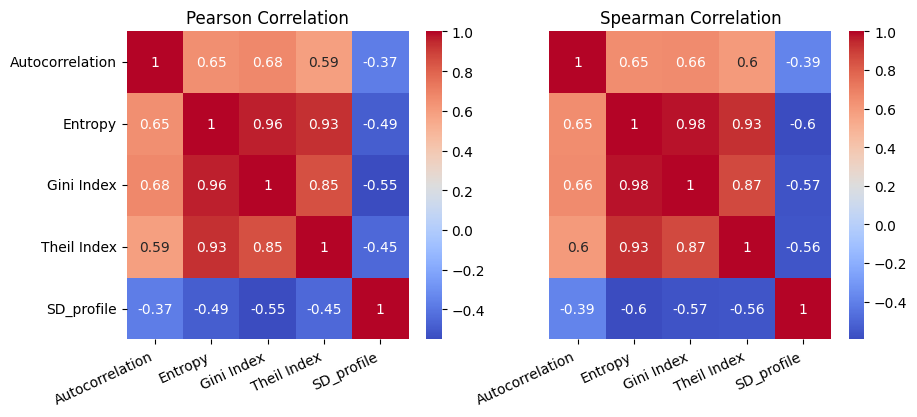

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# make correlation matrix 
corr_df = df[['Autocorrelation', 'Entropy', 'Gini Index', 'Theil Index', 'SD_profile']]

corr_pearson = corr_df.corr()
corr_spearman = corr_df.corr(method='spearman')

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Create a heatmap for the Pearson correlation
sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', ax=ax[0])
ax[0].set_title('Pearson Correlation')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=25, horizontalalignment='right')

# Create a heatmap for the Spearman correlation
sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', ax=ax[1])
# turn off labels on y axis 
ax[1].set_yticks([])
#rotate x tick
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=25, horizontalalignment='right')
ax[1].set_title('Spearman Correlation')


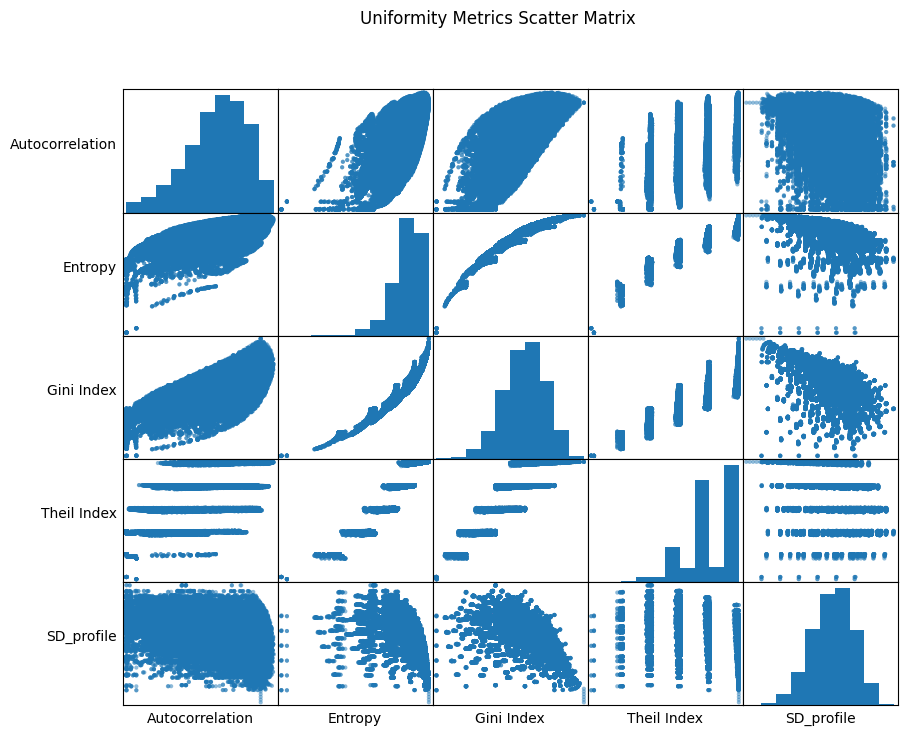

In [86]:
# plot scatter matrix 
import pandas as pd 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 8))

fig.suptitle('Uniformity Metrics Scatter Matrix')

pd.plotting.scatter_matrix(corr_df, figsize=(10, 10), ax=axes, alpha=0.5)

# Rotate the x-axis tick labels
for ax in axes.flatten():
    ax.tick_params(axis='x', labelrotation=0)
    # set vmin and vmax for all subplots
    # ax.set_ylim([0, 1])
    # ax.set_xlim([0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    # rotate axis labels
    ax.set_xlabel(ax.get_xlabel(), rotation = 0)
    ax.set_ylabel(ax.get_ylabel(), rotation = 0, ha = 'right')

# plt.savefig('Figures/periodicity_scatter_matrix.png', format='png')
plt.show()

In [ ]:
# pickle simulated_metagenes
import pickle

with open('simulated_metagenes.pkl', 'wb') as f:
    pickle.dump(simulated_metagenes, f)

In [ ]:
for i in simulated_metagenes['start']:
    fig = go.Figure()
    fig.add_trace(go.Scatter
                    (x = list(simulated_metagenes['start'][i].keys()), 
                     y = list(simulated_metagenes['start'][i].values()), 
                     mode='lines+markers'))
    fig.show()
    

In [ ]:
# Get the positions and counts from the metagene dictionary
metagene = simulated_metagenes['start'][0][0]

positions = list(metagene.keys())
counts = list(metagene.values())

# Create the bar plot
fig = go.Figure(data=go.Bar(x=positions, y=counts))

# Set the axis labels
fig.update_layout(xaxis_title='Position', yaxis_title='Count', title='Metagene with no periodicity')

# Show the plot
fig.show()

KeyError: 0